In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/feature_time_48k_2048_load_1.csv')

### EDA (Exploratory Data Analysis)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df.head(10)

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1
5,0.43726,-0.44435,0.021119,0.138763,0.140328,-0.131329,-0.168557,3.115990,6.644538,Ball_007_1
6,0.45353,-0.49129,0.021464,0.138461,0.140082,-0.114175,0.308107,3.237609,6.526352,Ball_007_1
7,0.43955,-0.45228,0.020860,0.150120,0.151526,-0.021955,-0.272298,2.900820,7.263885,Ball_007_1
8,0.49233,-0.37217,0.020244,0.145361,0.146729,0.074174,-0.421814,3.355377,7.248013,Ball_007_1
9,0.37154,-0.49087,0.018105,0.136393,0.137556,-0.136237,-0.097889,2.701005,7.597902,Ball_007_1


In [5]:
print("\nMissing values:")
print(df.isnull().sum())

print("\nFault distribution:")
print(df["fault"].value_counts())


Missing values:
max         0
min         0
mean        0
sd          0
rms         0
skewness    0
kurtosis    0
crest       0
form        0
fault       0
dtype: int64

Fault distribution:
fault
Ball_007_1    230
Ball_014_1    230
Ball_021_1    230
IR_007_1      230
IR_014_1      230
IR_021_1      230
OR_007_6_1    230
OR_014_6_1    230
OR_021_6_1    230
Normal_1      230
Name: count, dtype: int64


### Feature Distributions by Fault Type

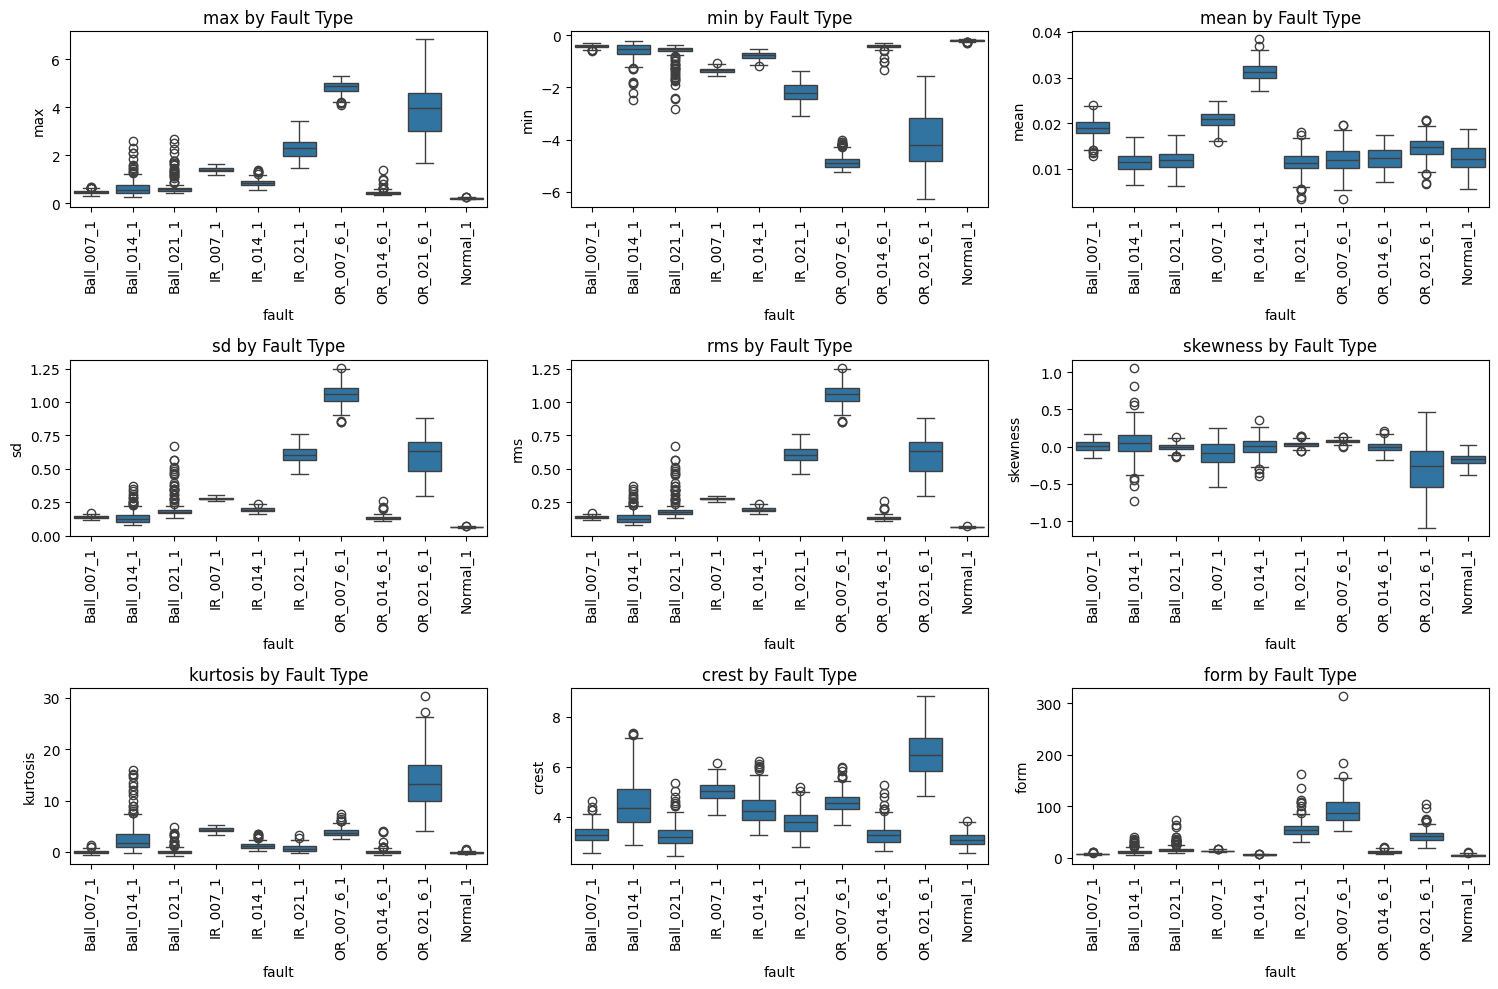

In [6]:
features = ['max', 'min', 'mean', 'sd', 'rms', 'skewness', 'kurtosis', 'crest', 'form']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='fault', y=feature, data=df)
    plt.title(f'{feature} by Fault Type')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

### Correlation heatmap

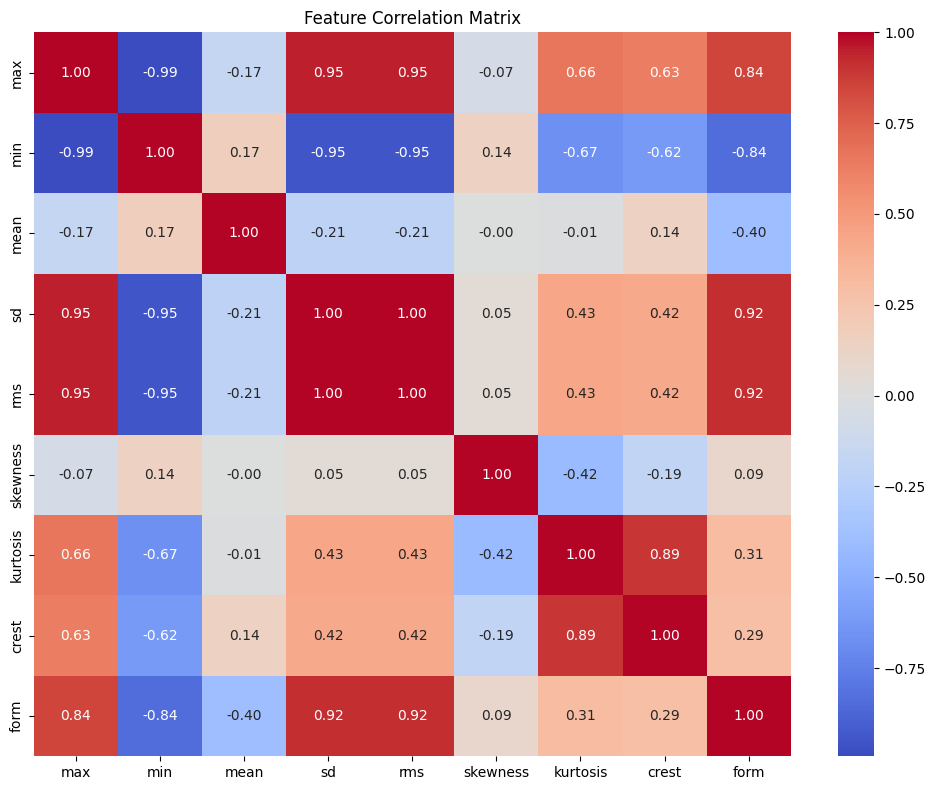

In [7]:
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [8]:
# Remove sd because it is highly correlated with rms
df.drop('sd', axis=1, inplace=True)

### Data Preprocessing

In [9]:
# Convert fault labels to numeric values
label_encoder = LabelEncoder()
df['fault_encoded'] = label_encoder.fit_transform(df['fault'])

# Map back to original labels if needed
fault_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("Fault mapping:", fault_mapping)

Fault mapping: {0: 'Ball_007_1', 1: 'Ball_014_1', 2: 'Ball_021_1', 3: 'IR_007_1', 4: 'IR_014_1', 5: 'IR_021_1', 6: 'Normal_1', 7: 'OR_007_6_1', 8: 'OR_014_6_1', 9: 'OR_021_6_1'}


In [10]:
# Split features and target
X = df[['max', 'min', 'mean', 'rms', 'skewness', 'kurtosis', 'crest', 'form']].values
y = df['fault_encoded'].values

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1610 samples
Validation set: 345 samples
Test set: 345 samples


In [11]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN (batch_size, n_channels, sequence_length)
# For CNN, we'll reshape our features as a sequence
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], 1, -1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], 1, -1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], 1, -1)

In [12]:
# Create PyTorch dataset
class MotorFaultDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create data loaders
batch_size = 32
train_dataset = MotorFaultDataset(X_train_cnn, y_train)
val_dataset = MotorFaultDataset(X_val_cnn, y_val)
test_dataset = MotorFaultDataset(X_test_cnn, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Model (CNN)

In [13]:
class MotorFaultCNN(nn.Module):
    def __init__(self, num_classes):
        super(MotorFaultCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )

        # Calculate the size after convolutions and pooling
        # This needs to match the flattened output size from conv layers
        self.fc_input_size = 128

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        # Apply CNN layers
        x = self.conv_layers(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Apply fully connected layers
        x = self.fc_layers(x)
        return x

In [14]:
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

# Initialize model, loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MotorFaultCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

MotorFaultCNN(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4

### Training

In [15]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs}: "
                f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
                f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
            )

    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
)

Epoch 1/50: Train Loss: 1.5040, Train Acc: 0.5957, Val Loss: 1.0559, Val Acc: 0.7826
Epoch 5/50: Train Loss: 0.3836, Train Acc: 0.8919, Val Loss: 0.2740, Val Acc: 0.9188
Epoch 10/50: Train Loss: 0.2535, Train Acc: 0.9174, Val Loss: 0.3068, Val Acc: 0.8725
Epoch 15/50: Train Loss: 0.2301, Train Acc: 0.9273, Val Loss: 0.1836, Val Acc: 0.9333
Epoch 20/50: Train Loss: 0.2009, Train Acc: 0.9379, Val Loss: 0.2370, Val Acc: 0.9159
Epoch 25/50: Train Loss: 0.2393, Train Acc: 0.9217, Val Loss: 0.2453, Val Acc: 0.9188
Epoch 30/50: Train Loss: 0.1947, Train Acc: 0.9360, Val Loss: 0.2354, Val Acc: 0.9217
Epoch 35/50: Train Loss: 0.1707, Train Acc: 0.9441, Val Loss: 0.1892, Val Acc: 0.9246
Epoch 40/50: Train Loss: 0.1478, Train Acc: 0.9466, Val Loss: 0.1868, Val Acc: 0.9304
Epoch 45/50: Train Loss: 0.1651, Train Acc: 0.9497, Val Loss: 0.1612, Val Acc: 0.9420
Epoch 50/50: Train Loss: 0.1717, Train Acc: 0.9404, Val Loss: 0.2003, Val Acc: 0.9333


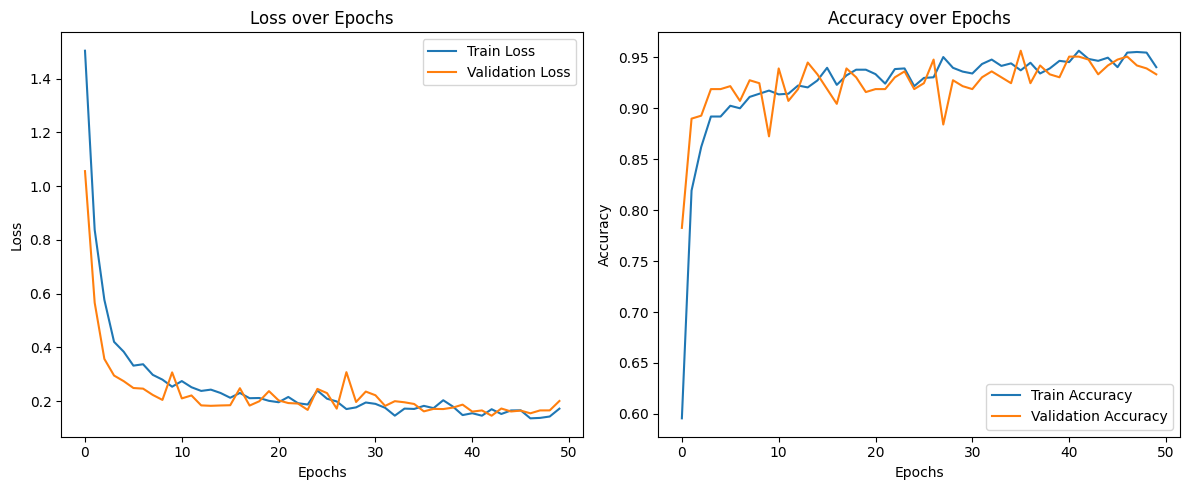

In [17]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation


Test Accuracy: 0.9246


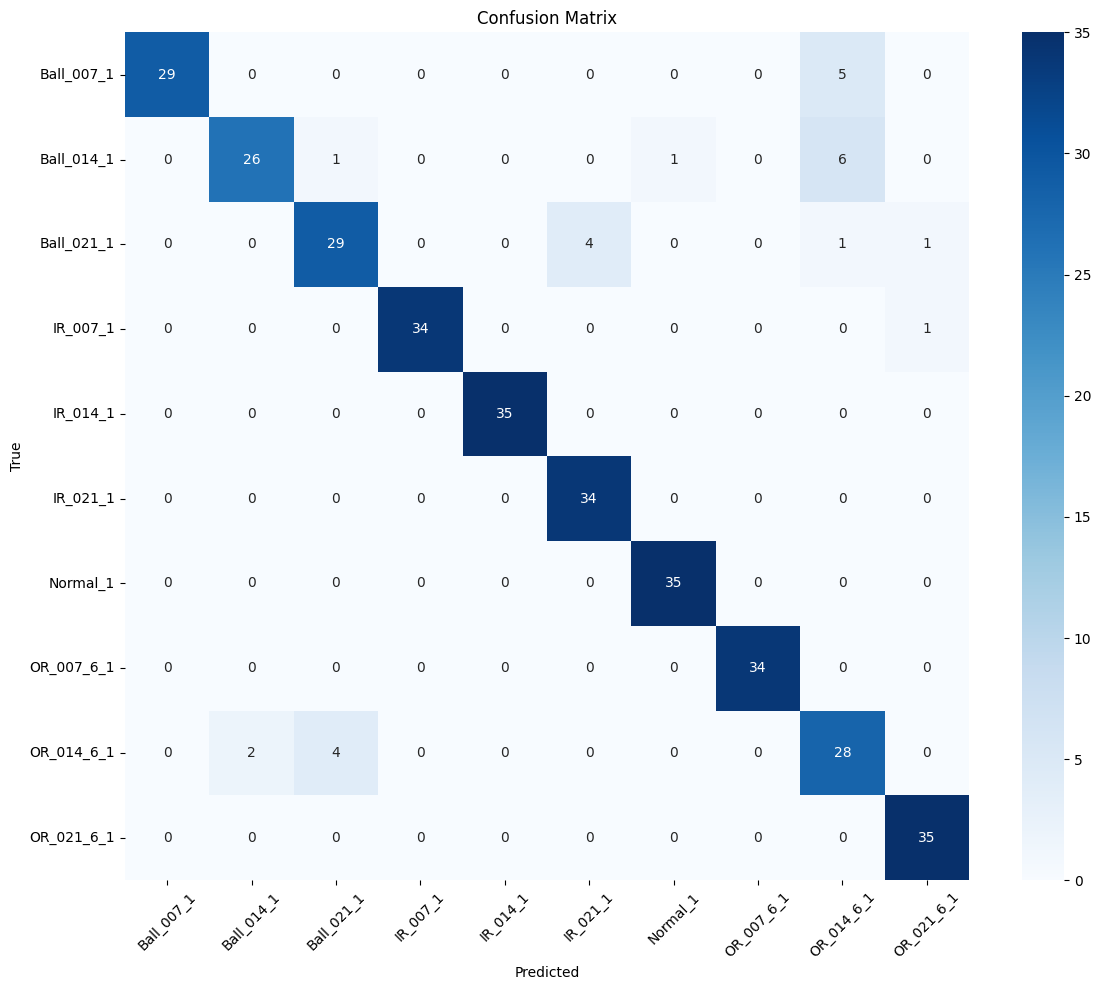

In [18]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[fault_mapping[i] for i in range(num_classes)],
    yticklabels=[fault_mapping[i] for i in range(num_classes)],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Print classification report
target_names = [fault_mapping[i] for i in range(num_classes)]
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

  Ball_007_1       1.00      0.85      0.92        34
  Ball_014_1       0.93      0.76      0.84        34
  Ball_021_1       0.85      0.83      0.84        35
    IR_007_1       1.00      0.97      0.99        35
    IR_014_1       1.00      1.00      1.00        35
    IR_021_1       0.89      1.00      0.94        34
    Normal_1       0.97      1.00      0.99        35
  OR_007_6_1       1.00      1.00      1.00        34
  OR_014_6_1       0.70      0.82      0.76        34
  OR_021_6_1       0.95      1.00      0.97        35

    accuracy                           0.92       345
   macro avg       0.93      0.92      0.92       345
weighted avg       0.93      0.92      0.92       345



### Saving the model

In [20]:
# Save the trained model
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler": scaler,
        "label_encoder": label_encoder,
        "fault_mapping": fault_mapping,
    },
    "motor_fault_cnn_model.pth",
)

print("Model saved successfully!")

Model saved successfully!


In [21]:
# Function to load the model for future use
def load_model(model_path, input_size, num_classes):
    checkpoint = torch.load(model_path)
    model = MotorFaultCNN(input_size, num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    scaler = checkpoint["scaler"]
    label_encoder = checkpoint["label_encoder"]
    fault_mapping = checkpoint["fault_mapping"]

    return model, scaler, label_encoder, fault_mapping


def predict_from_raw_parameters(model, scaler, label_encoder, raw_params, device=None):
    """
    Predict fault type from raw input parameters.

    Parameters:
    -----------
    model : PyTorch model
        The trained fault classification model
    scaler : StandardScaler
        The scaler used to preprocess the data
    label_encoder : LabelEncoder
        The encoder used to transform fault labels
    raw_params : dict or list of dicts
        Raw parameters for prediction. Each dict should contain:
        'max', 'min', 'mean', 'sd', 'rms', 'skewness', 'kurtosis', 'crest', 'form'
    device : torch.device, optional
        Device to run the model on, defaults to 'cuda' if available else 'cpu'

    Returns:
    --------
    list of dicts
        List containing prediction results for each input sample
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    if isinstance(raw_params, dict):
        raw_params = [raw_params]

    feature_order = [
        "max",
        "min",
        "mean",
        "rms",
        "skewness",
        "kurtosis",
        "crest",
        "form",
    ]
    features = []

    for sample in raw_params:
        if not all(key in sample for key in feature_order):
            missing = [key for key in feature_order if key not in sample]
            raise ValueError(f"Missing required features: {', '.join(missing)}")

        features.append([float(sample[key]) for key in feature_order])

    features = np.array(features)

    features_scaled = scaler.transform(features)

    features_cnn = features_scaled.reshape(features_scaled.shape[0], 1, -1)

    features_tensor = torch.FloatTensor(features_cnn).to(device)

    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        probs_np = probabilities.cpu().numpy()
        _, predicted = torch.max(outputs, 1)

    predicted_faults = label_encoder.inverse_transform(predicted.cpu().numpy())

    results = []
    for i, pred_fault in enumerate(predicted_faults):
        fault_probs = {
            fault: float(probs_np[i, idx])
            for idx, fault in enumerate(label_encoder.classes_)
        }

        top_probs = sorted(fault_probs.items(), key=lambda x: x[1], reverse=True)[:3]

        results.append(
            {
                "predicted_fault": pred_fault,
                "confidence": float(probs_np[i, predicted[i]]),
                "top_probabilities": {fault: prob for fault, prob in top_probs},
                "all_probabilities": fault_probs,
            }
        )

    return results[0] if len(results) == 1 else results

In [22]:
input_sample = {
    'max': 0.35986,
    'min': -0.4189,
    'mean': 0.0178404615917969,
    'rms': 0.1240064614036,
    'skewness': -0.118571177953009,
    'kurtosis': -0.0422192362415159,
    'crest': 2.90194555934286,
    'form': 6.95085498575995
}

result = predict_from_raw_parameters(model, scaler, label_encoder, input_sample)
print(f"Predicted fault: {result['predicted_fault']}")
print(f"Confidence: {result['confidence']:.4f}")
print("\nTop probabilities:")
for fault, prob in result['top_probabilities'].items():
    print(f"  {fault}: {prob:.4f}")


Predicted fault: Ball_007_1
Confidence: 0.9973

Top probabilities:
  Ball_007_1: 0.9973
  Ball_021_1: 0.0011
  IR_021_1: 0.0007
